In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random

# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense,Input,Dropout, Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import image_dataset_from_directory

# Display images

In [3]:
picture_size = 48
expression = 'happy'

# Determine if running on Kaggle or locally
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    folder_path = "/kaggle/input/images/"
else:
    folder_path = ".\\images\\"



In [4]:
# Paths
expression_folder = os.path.join(folder_path, "train", expression)
image_files = os.listdir(expression_folder)


In [40]:
# Displays 4 pictures from a folder
def show_random(image_file,random_images,expression_folder):
    
    plt.figure(figsize=(6, 6))  
    for i, image_file in enumerate(random_images, 1):
        full_path = os.path.join(expression_folder, image_file)
        plt.subplot(1, 4, i)
        img = load_img(full_path, target_size=(picture_size, picture_size))
        plt.imshow(img)
        plt.axis('off')
    plt.title(f'Images from {expression_folder}')
    plt.show()


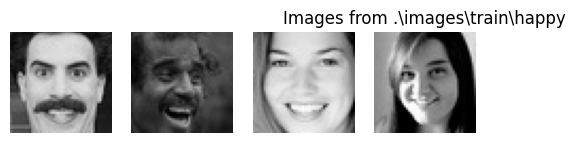

In [41]:
# Generate some random picures from the train folder
random_images = random.sample(image_files, 4)
show_random(image_files,random_images,expression_folder)

# Making Training and Validation Data

In [5]:
batch_size = 250
rnState = 50
folder_path = ".\\images\\"
# Load training dataset
train_set = image_dataset_from_directory(
    directory= folder_path + "train",
    labels='inferred',                    # (labels are generated from the directory structure)
    label_mode='categorical',             # means that the labels are encoded as a categorical vector (for categorical_crossentropy loss).
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(picture_size, picture_size),
    shuffle=True,
    seed = rnState
)

# Load validation dataset
val_set = image_dataset_from_directory(
    directory= folder_path + "validation",
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(picture_size, picture_size),
    shuffle=False,
    seed = rnState
)

Found 28639 files belonging to 7 classes.
Found 7047 files belonging to 7 classes.


## Building a model

In [6]:
from keras.regularizers import l2

def make_model():
    model = Sequential()

    # 1st CNN part
    model.add(Input(shape=(48, 48, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # 2nd CNN part
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # 3rd CNN part
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    # 4th CNN part
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    # Fully connected part
    model.add(Dense(512,activation='relu', kernel_regularizer=l2(0.01))) # Added L2 regularization , kernel_regularizer=l2(0.01)
    model.add(Dropout(0.5))

    # Output layer
    classes = 7
    model.add(Dense(classes, activation='softmax'))

    # Compile the model
    #model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Fitting

In [7]:
model = make_model()

print_results = 1

# ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
                                filepath= "./bestmodel.keras", 
                                monitor='val_accuracy', 
                                verbose=print_results, 
                                save_best_only=True, 
                                mode='max')

# EarlyStopping callback to stop training when validation loss stops improving
early = EarlyStopping(
                            monitor='val_loss',    # Besides val_loss, consider monitoring val_accuracy as well.
                            min_delta=0,
                            patience=10,
                            verbose=print_results,
                            restore_best_weights=True)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.5,   # 0.7
                            patience=5,
                            verbose=print_results,
                            min_delta=0.0001)

# List of callbacks
callbacks_list = [
                   early, 
                   checkpoint, 
                   reduce_lr
                 ]




In [ ]:
# Number of training epochs
epochs = 250

# Calculate steps per epoch
steps_per_epoch =  len(train_set) // batch_size
validation_steps = len(val_set) // batch_size

# Train the model
fitted = model.fit(
            train_set,
            batch_size=batch_size,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_set,
            validation_steps=validation_steps,
            callbacks=callbacks_list
            )

In [8]:
# Save the model weights with old method
#model.save_weights('Dlkk.weights.h5')

# Load the best model weights
model.load_weights('bestmodel1.keras')
print(f"Loaded Model: {model}")


# evaluate the model with the best weights
score = model.evaluate(val_set, verbose=0)
print(f'Validation loss: {score[0]}')
print(f'Validation accuracy: {score[1]}')

c:\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded Model: <Sequential name=sequential, built=True>
Validation loss: 1.1444319486618042
Validation accuracy: 0.6472257971763611


## Plotting

In [ ]:
def save_history_plots(history, filename_prefix='history'):
    #plt.style.use('dark_background')

    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(fitted.history['loss'], label='Training Loss')
    plt.plot(fitted.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(fitted.history['accuracy'], label='Training Accuracy')
    plt.plot(fitted.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    
    # Save the plots so we can show them later if we want to load a saved model
    plt.savefig(f'{filename_prefix}_plots.png')
    plt.close()

#-------------------------------------------------------------------------------    
# Save the history plots
save_history_plots(fitted, filename_prefix='training_history')

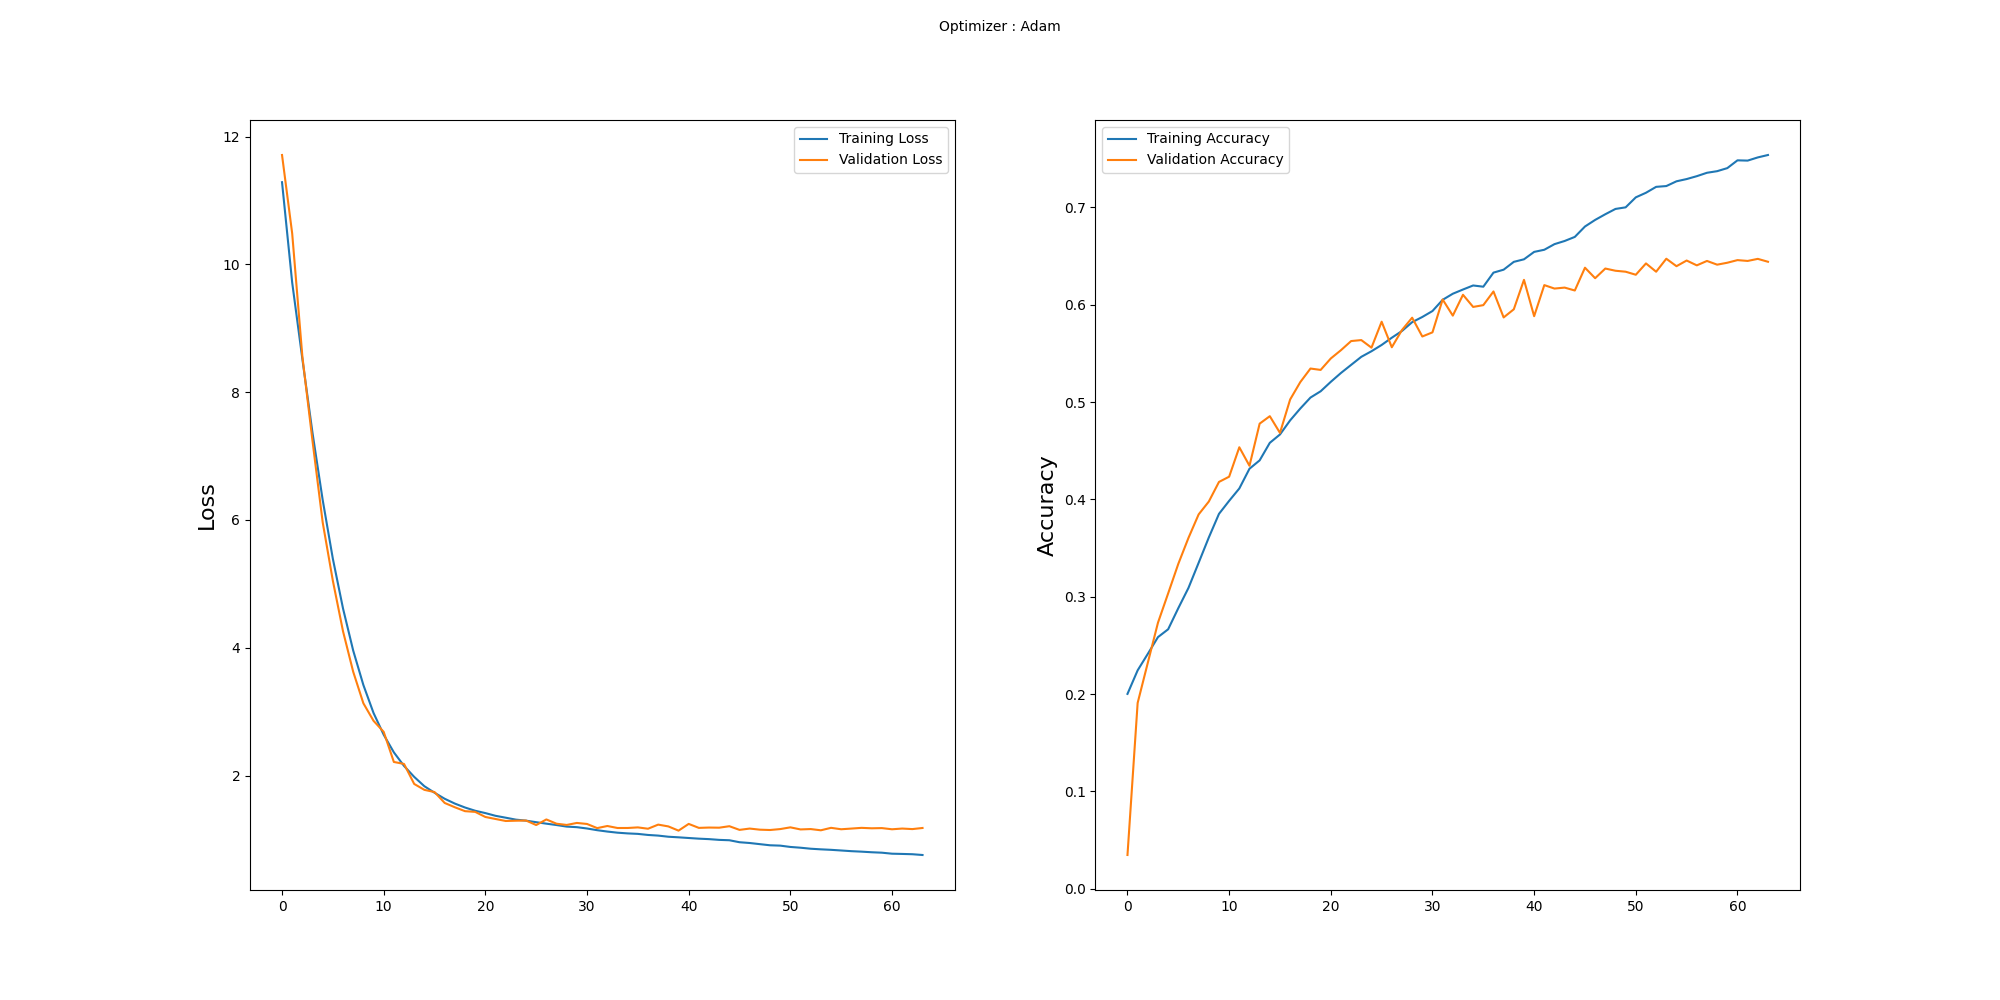

In [61]:
from IPython.display import Image, display

# Load and display the saved history plots
display(Image(filename='training_history_plots1.png',width=800, height='auto'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


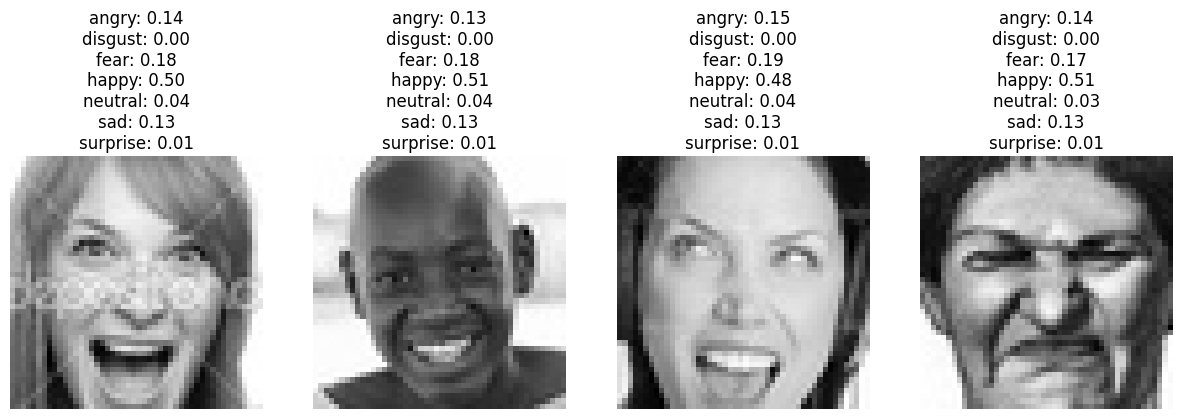

In [16]:

# Define the local path and model to predict without camera
folder_path = "C:/Users/D.B/Desktop/Utbildning/EC Utbildning/Github-uploads/Data_science/kunskapskontroll-2/Predictions"
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def load_and_preprocess_image(filepath, target_size=(48, 48)):

    img = image.load_img(filepath, target_size=target_size, color_mode='grayscale')
    img_array = image.img_to_array(img)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)  

    # Normalize the image
    img_array = img_array.astype('float32') / 255.0 
    return img_array

def predict_image(model, img_array):

    predictions = model.predict(img_array)  
    # Return the array of probabilities for the single image
    return predictions[0]  

def show_image_with_prediction(img_path, prediction):

    img = image.load_img(img_path, target_size=(48, 48), color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    prediction_str = "\n".join([f'{class_names[i]}: {prediction[i]:.2f}' for i in range(len(class_names))])
    plt.title(prediction_str)
    plt.axis('off')

def display_with_predictions(folder_path, model, num_images=4):
    
    # Get all image files from the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Randomly select some images
    selected_files = random.sample(image_files, num_images)
    plt.figure(figsize=(15, 10))
    
    for i, img_path in enumerate(selected_files):
        img_array = load_and_preprocess_image(img_path)
        prediction = predict_image(model, img_array)
        
        plt.subplot(1, num_images, i + 1)
        show_image_with_prediction(img_path, prediction)
    
    plt.show()

# Call the function to predict
display_with_predictions(folder_path, model, num_images=4)